In [1]:
import jax.numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, nn
from jax.experimental.ode import odeint

import numpyro as npyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import substitute, condition

from numpyro.distributions.transforms import AffineTransform, ExpTransform, ComposeTransform

npyro.enable_validation(True)
sns.set(style='white', context='notebook', palette='muted')

In [2]:
# load data from various github repositories 
import pandas as pd

### population per region

df_N = pd.read_html('http://en.comuni-italiani.it/regionip.html')
df_N = df_N[-5]

columns = df_N.loc[0].values
df_N = df_N.loc[1:20, 1:2]
df_N.columns = columns[1:-2]
df_N['Region'] = ['Lombardia', 
                  'Lazio', 
                  'Campania', 
                  'Sicilia', 
                  'Veneto',
                  'Emilia-Romagna',
                  'Piemonte',
                  'Puglia',
                  'Toscana',
                  'Calabria',
                  'Sardegna',
                  'Liguria',
                  'Marche',
                  'Abruzzo',
                  'Friuli Venezia Giulia',
                  'Trentino-Alto Adige',
                  'Umbria',
                  'Basilicata',
                  'Molise',
                  "Valle d'Aosta"]

df_N['Population'] = df_N['Population'].values.astype(np.int32)
                  
# Note that the region of Trentino-Alto Adige covers, regions of P.A. Bolzano and P.A. Trento which
# one gets from the italy's Covid repository on github. Hence we will combine them in one in the 
# table bellow. 
#########################
# Load national data in Italy
df_it_national = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

df_it_national = df_it_national[['data', 
                                 'totale_positivi', 
                                 'dimessi_guariti', 
                                 'deceduti', 
                                 'totale_casi', 
                                 'casi_testati',
                                 'nuovi_positivi']]

df_it_national.rename(columns={'data': 'date', 
                               'casi_testati': 'total tests',
                               'totale_positivi': 'I',
                               'totale_casi':'X',
                               'nuovi_positivi': 'new daily cases'}, 
                      inplace=True)

df_it_national['R'] = df_it_national['deceduti'] + df_it_national['dimessi_guariti']

# Load and format region specific data.
df_it_regions = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-regioni/dpc-covid19-ita-regioni.csv')

df_it_regions = df_it_regions[['data',
                               'denominazione_regione',
                               'totale_positivi', 
                               'dimessi_guariti', 
                               'deceduti', 
                               'totale_casi', 
                               'casi_testati', 
                               'nuovi_positivi']]

df_it_regions.rename(columns={'data': 'date', 
                              'casi_testati': 'total tests', 
                              'denominazione_regione': 'region',
                              'totale_positivi': 'I',
                              'totale_casi':'X',
                              'nuovi_positivi': 'new daily cases'}, 
                     inplace=True)

df_it_regions = df_it_regions.set_index('date')

loc_bolz = df_it_regions.region == 'P.A. Bolzano'
loc_tren = df_it_regions.region == 'P.A. Trento'

df_ta = df_it_regions.loc[loc_bolz, 'I':] + \
        df_it_regions.loc[loc_tren, 'I':]

df_ta['region'] = 'Trentino-Alto Adige'

df_it_regions = df_it_regions.append(df_ta).reset_index()
df_it_regions = df_it_regions.drop(df_it_regions[df_it_regions.region == 'P.A. Bolzano'].index)
df_it_regions = df_it_regions.drop(df_it_regions[df_it_regions.region == 'P.A. Trento'].index)

df_it_regions['R'] = (df_it_regions['deceduti'] + df_it_regions['dimessi_guariti'])

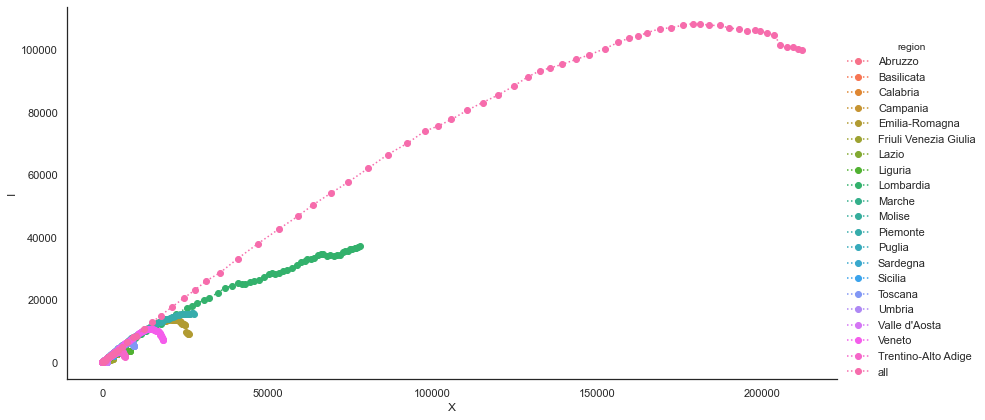

In [3]:
df_it_national['region'] = 'all'
df_it_regions = df_it_regions.append(df_it_national)

g = sns.FacetGrid(df_it_regions, hue='region', height=6, aspect=2)

g.map(plt.plot, 'X', 'I', marker='o', linestyle=':').add_legend()


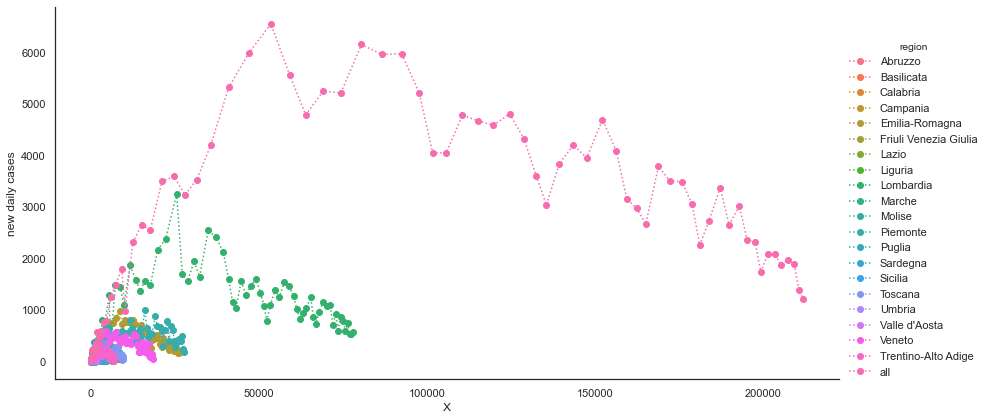

In [4]:
g = sns.FacetGrid(df_it_regions, hue='region', height=6, aspect=2)
g.map(plt.plot, 'X', 'new daily cases', marker='o', linestyle=':').add_legend()

Generative model for controlled SIR system

In [42]:
def dz_dt_fixed(z, t, theta):
    """
    Controleld SIR equations.
    """
    X, I, R = z
    tau = theta['tau']
    alpha = theta['alpha']
    g0 = theta['g0']
    a = theta['a']

    g = g0/(1 + alpha * a * X + (1 - a) * alpha * I)
    dX_dt = g * (1 - X) * I/tau 
    dI_dt = (g * (1 - X) - 1) * I/tau
    dR_dt = I/tau
    return np.stack([dX_dt, dI_dt, dR_dt])


def dz_dt_dyn(z, t, theta):
    """
    Controleld SIR equations.
    """
    X, I, R = z
    tau = theta['tau']
    alpha = theta['alpha']
    g0 = theta['g0']
    a = nn.sigmoid(- theta['k'] * (t - theta['b']))

    g = g0/(1 + alpha * a * X + (1-a) * alpha * I)
    dX_dt = g * (1 - X) * I/tau 
    dI_dt = (g * (1 - X) - 1) * I/tau
    dR_dt = I/tau
    return np.stack([dX_dt, dI_dt, dR_dt])

In [6]:
T = 50
ts = np.arange(0, float(T), 1/5.)
z_init = np.array([1e-6, 1e-6, 0.])
theta = {'tau': 2. * np.ones(1),
         'alpha': 0. * np.ones(1),
         'g0': 3. * np.ones(1),
         'a': 1. * np.ones(1)}

z0 = odeint(dz_dt_fixed, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)

theta['alpha'] = 10. * np.ones(1)
theta['a'] = 1. * np.ones(1)
z10_1 = odeint(dz_dt_fixed, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)

theta['a'] = 0. * np.zeros(1)
z10_0 = odeint(dz_dt_fixed, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)

(0.0, 1.0)

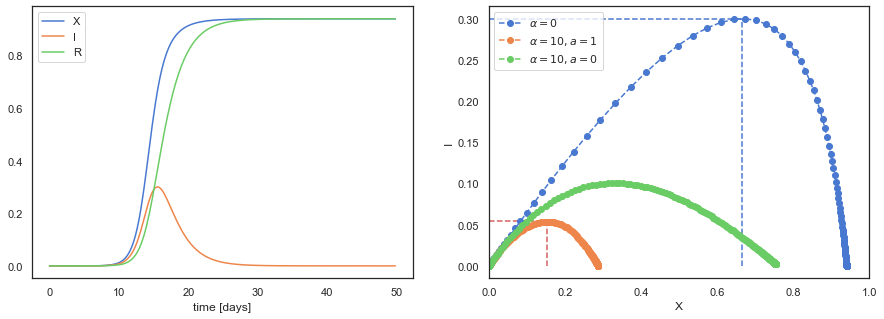

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(ts, z0)
axes[0].set_xlabel('time [days]');
axes[0].legend(labels=['X', 'I', 'R']);

# X peak = (g_0 - 1)/ (g_0 + alpha)
X_peak = 2/3
# I_peak = (g_0 - 1)/g_0 + (1 + alpha)/g_0 * [ln(1 + alpha) - ln(g_0 + alpha)]
I_peak = (3 - 1)/3 + 1/3 * (- np.log(3))

axes[1].plot(z0[:, 0], z0[:, 1], 'o--', label=r'$\alpha=0$');
axes[1].vlines(X_peak, 0, I_peak, 'b', linestyle='--')
axes[1].hlines(I_peak, 0, X_peak, 'b', linestyle='--')

X_peak = (3 - 1)/(3 + 10)
I_peak = (3 - 1)/3 + (1 + 10)/3 * (np.log(1 + 10) - np.log(3 + 10))

axes[1].plot(z10_1[:, 0], z10_1[:, 1], 'o--', label=r'$\alpha=10, a=1$');
axes[1].vlines(X_peak, 0, I_peak, 'r', linestyle='--')
axes[1].hlines(I_peak, 0, X_peak, 'r', linestyle='--')

axes[1].plot(z10_0[:, 0], z10_0[:, 1], 'o--', label=r'$\alpha=10, a=0$');
axes[1].set_xlabel('X');
axes[1].set_ylabel('I');

axes[1].legend();
axes[1].set_xlim([0., 1.])

In [44]:
def model(T, N, data, obs=None, K=1):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, R, I
    :param numpy.ndarray obs: 
    :param int K: number of categories
    """
    
    # infer the fraction of the total population that can be infected. With this we assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.
    
    # initial conditions
    m_init = np.array([1e-3, 1e-5])
    z_init = npyro.sample("z_init", dist.Beta(1e5 * m_init, 1e5 * (1 - m_init)))
    z_init = np.concatenate([z_init.sum(-1, keepdims=True), z_init], -1)
    
    # population fraction
    f = npyro.sample('f', dist.Beta(1., 9.))
        
    # measurement times
    ts = np.arange(float(T))
    # parameters of dz_dt
    tau = npyro.sample('tau', dist.InverseGamma(3., 6.))
    alpha = npyro.sample('alpha', dist.InverseGamma(2., 2.))
    g0 = npyro.sample('g0', dist.InverseGamma(3., 4.))
    a = npyro.sample('a', dist.Beta(1., 1.))
    theta = {'tau': tau,
             'alpha': alpha,
             'g0': g0, 
             'a': a}
    
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt_fixed, z_init, ts, theta, rtol=1e-6, atol=1e-4, mxstep=1000)
    X = npyro.deterministic('X', z[..., 0])
    I = npyro.deterministic('I', z[..., 1])

    # measurement errors
    nu_X = npyro.sample("nu_X", dist.Gamma(40., 2.))

    # measured total infected
    total_count = f * float(N)
    dX = np.diff(np.concatenate([np.zeros(K), X], 0), axis=0)
    daily = total_count * dX
    daily = npyro.deterministic('daily', np.where(daily > 0, daily, 0.))

    scale = 1. / np.sqrt(nu_X)
    npyro.sample("obs", dist.LogNormal(np.log(total_count * X), scale), obs=obs)
    
data = {'R': np.array(df_it_national['R'].values),
        'I': np.array(df_it_national['I'].values),
        'X': np.array(df_it_national['X'].values)}

N = df_N['Population'].sum()
T = len(df_it_national)
    
with npyro.handlers.seed(rng_seed=1):
    model(T, N, data)

In [105]:
return_sites = ['tau', 'alpha', 'g0', 'a', 'nu', 'obs', 'X', 'daily', 'I', 'f']
params = {'z_init': np.array([[1e-6, 0.]]),
          'g0': 1.20 * np.ones(1),
          'a': 1. * np.ones(1), 
          'tau': 2. * np.ones(1),
          'alpha': 180. * np.ones(1),
          'nu': 100. * np.ones(1), 
          'f' : 1. * np.ones(1)}
prior_predictive = Predictive(model, posterior_samples=params, num_samples=1, return_sites=return_sites)
prior_sample = prior_predictive.get_samples(random.PRNGKey(43535), T, N, data)

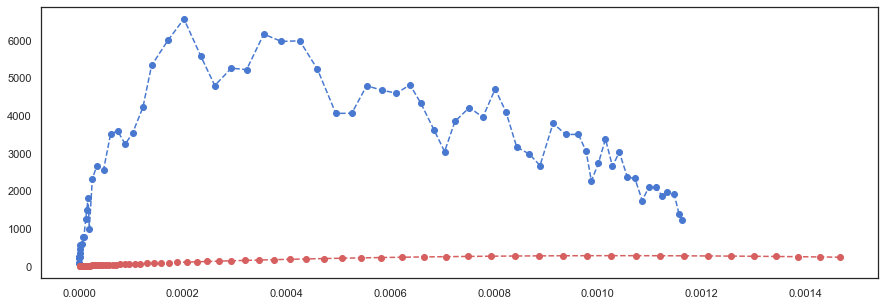

In [108]:
fig, axes = plt.subplots(figsize=(15, 5))

plt.plot(data['X']/(params['f'] * N), df_it_national['new daily cases'], 'o--')
plt.plot(prior_sample['X'][0], prior_sample['daily'][0], 'ro--');

In [45]:
num_warmup = 1000
num_samples = 1000
num_chains = 1

obs = data['X']

# fix a = 1
nuts = NUTS(condition(model, {'a': 1. - 1e-6}), 
            dense_mass=True)
mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
mcmc.run(random.PRNGKey(24323), T=T, N=N, data=data, obs=obs)
mcmc.print_summary()
samples1 = mcmc.get_samples()

# fix a = 0
nuts = NUTS(condition(model, {'a': 0. + 1e-6}), dense_mass=True)
mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
mcmc.run(random.PRNGKey(2432323), T=T, N=N, data=data, obs=obs)
mcmc.print_summary()
samples2 = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:35<00:00, 57.04it/s, 27 steps of size 1.22e-01. acc. prob=0.84]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.37      1.08      2.26      0.46      3.79    215.76      1.00
         f      0.01      0.00      0.01      0.00      0.01    429.15      1.00
        g0      3.14      0.94      2.97      1.90      4.40    269.56      1.00
      nu_X     32.97      3.78     32.84     26.86     38.81    525.91      1.00
       tau      9.66      3.71      9.00      4.50     14.39    263.65      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    499.08      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    895.77      1.00

Number of divergences: 21


sample: 100%|██████████| 2000/2000 [00:30<00:00, 65.06it/s, 15 steps of size 1.67e-01. acc. prob=0.92]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.25      1.40      4.18      1.84      6.33    224.77      1.00
         f      0.00      0.00      0.00      0.00      0.01    675.08      1.00
        g0      2.50      0.58      2.37      1.68      3.21    145.81      1.01
      nu_X     34.90      4.19     34.75     28.63     41.66    542.13      1.00
       tau      6.65      2.18      6.18      3.54      9.40    150.20      1.01
 z_init[0]      0.00      0.00      0.00      0.00      0.00    647.37      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    890.21      1.00

Number of divergences: 4


Text(0.5, 1.0, 'fit for $a = 0$')

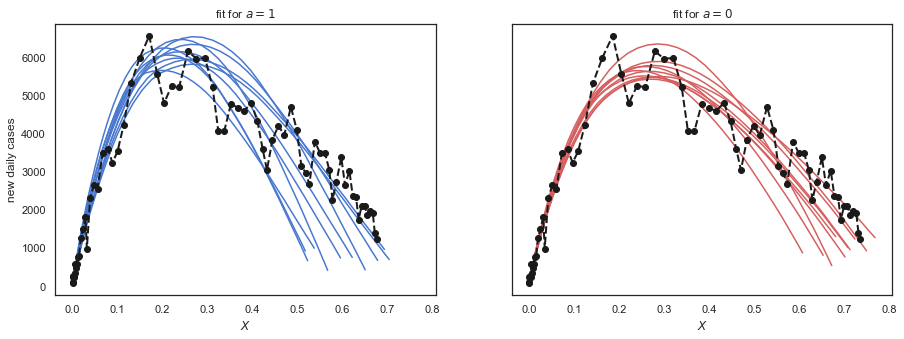

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for i in range(num_samples):
    if i % 100 == 0:
        axes[0].plot(samples1['X'][i], samples1['daily'][i], 'b');
        axes[1].plot(samples2['X'][i], samples2['daily'][i], 'r');
        
axes[0].plot(data['X']/ (samples1['f'].mean() * float(N)), df_it_national['new daily cases'], 'ko--', lw=2);
axes[1].plot(data['X']/ (samples2['f'].mean() * float(N)), df_it_national['new daily cases'], 'ko--', lw=2);

axes[0].set_ylabel('new daily cases');
axes[0].set_xlabel(r'$X$');
axes[1].set_xlabel(r'$X$');

axes[0].set_title(r'fit for $a = 1$')
axes[1].set_title(r'fit for $a = 0$')

In [54]:
def model2(T, N, data, obs=[None, None], K=1):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, R, I
    :param numpy.ndarray obs: 
    :param int K: number of categories
    """
    
    # infer the fraction of the total population that can be infected. With this we assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.
    with npyro.plate('K', K):
         f = npyro.sample('f', dist.Beta(1., 9.))
    I_data = data['I']
    R_data = data['R']
    X_data = data['X']
    dX_data = np.diff(np.concatenate([np.zeros(K), X_data], 0), axis=0)
    
    # initial population
    m_init = np.array([1e-3, 1e-5])
    z_init = npyro.sample("z_init", dist.Beta(1e5 * m_init, 1e5 * (1 - m_init)))
    z_init = np.concatenate([z_init.sum(-1, keepdims=True), z_init], -1)

    # measurement times
    ts = np.arange(float(T))
    # parameters of dz_dt
    tau = npyro.sample('tau', dist.InverseGamma(3., 6.))
    alpha = npyro.sample('alpha', dist.InverseGamma(2., 2.))
    g0 = npyro.sample('g0', dist.InverseGamma(3., 4.))
    b = npyro.sample('b', dist.Cauchy(float(T)/2, 1.))
    k = npyro.sample('k', dist.Cauchy(0., .1))
    theta = {'tau': tau,
             'alpha': alpha,
             'g0': g0, 
             'b': b,
             'k': k}
    
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt_dyn, z_init, ts, theta, mxstep=500)
    X = npyro.deterministic('X', z[..., 0])
    I = npyro.deterministic('I', z[..., 1])
    
    # measurement errors
    nu_X = npyro.sample("nu_X", dist.Gamma(40., 2.))

    # new daily cases - prediction
    total_count = f * float(N)
    dX = np.diff(np.concatenate([np.zeros(K), X], 0), axis=0)
    daily = total_count * dX
    daily = npyro.deterministic('daily', np.where(daily > 0, daily, 0.))
    
    nu_X = 1e3 * dX * nu_X
    
    o_x = dist.Normal(0., np.ones(T))
    o_x_1 = dist.TransformedDistribution(o_x, AffineTransform(np.log(total_count * X), 1./np.sqrt(nu_X)))
    npyro.sample("obs", dist.TransformedDistribution(o_x_1, ExpTransform()), obs=obs)
    
data = {'R': np.array(df_it_national['R'].values),
        'I': np.array(df_it_national['I'].values),
        'X': np.array(df_it_national['X'].values)}

N = df_N['Population'].sum()
T = len(df_it_national)
    
with npyro.handlers.seed(rng_seed=1):
    model2(T, N, data)

In [55]:
num_warmup = 1000
num_samples = 1000
num_chains = 1

obs = data['X']

In [57]:
# fix a = 1
nuts = NUTS(condition(model2, {'b': 200., 'k': 1.}), dense_mass=True)
mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
mcmc.run(random.PRNGKey(248324743), T=T, N=N, data=data, obs=obs)
mcmc.print_summary()
samples1 = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:49<00:00, 40.14it/s, 7 steps of size 1.89e-01. acc. prob=0.91]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.37      0.59      4.34      3.47      5.42    398.16      1.00
      f[0]      0.01      0.00      0.00      0.00      0.01    387.77      1.01
        g0      7.34      2.10      6.92      4.09     10.18    202.08      1.02
      nu_X     32.71      3.83     32.49     26.41     38.51    664.07      1.00
       tau     26.90      8.29     25.37     13.89     38.23    201.61      1.02
 z_init[0]      0.00      0.00      0.00      0.00      0.00    644.21      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    886.93      1.01

Number of divergences: 7


In [58]:
# fix a = 0
nuts = NUTS(condition(model2, {'b': -200., 'k': 1.}), dense_mass=True)
mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
mcmc.run(random.PRNGKey(248324743), T=T, N=N, data=data, obs=obs)
mcmc.print_summary()
samples2 = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:52<00:00, 37.77it/s, 15 steps of size 1.50e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.94      0.55      4.90      3.98      5.81    702.27      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    379.12      1.00
        g0      3.52      0.68      3.40      2.46      4.51    145.00      1.00
      nu_X     33.12      3.79     32.94     27.01     39.22    732.13      1.00
       tau     10.85      2.70     10.34      6.57     14.78    148.81      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    528.84      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1089.82      1.00

Number of divergences: 1


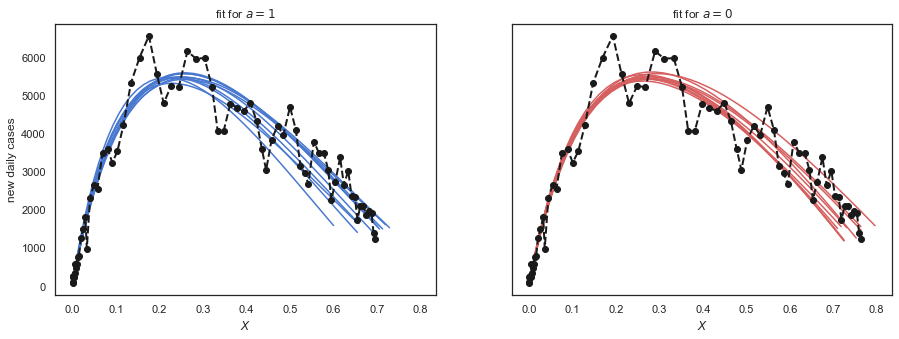

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for i in range(num_samples):
    if i % 100 == 0:
        axes[0].plot(samples1['X'][i], samples1['daily'][i], 'b');
        axes[1].plot(samples2['X'][i], samples2['daily'][i], 'r');
        
axes[0].plot(data['X']/ (samples1['f'].mean() * float(N)), df_it_national['new daily cases'], 'ko--', lw=2);
axes[1].plot(data['X']/ (samples2['f'].mean() * float(N)), df_it_national['new daily cases'], 'ko--', lw=2);

axes[0].set_ylabel('new daily cases');
axes[0].set_xlabel(r'$X$');
axes[1].set_xlabel(r'$X$');

axes[0].set_title(r'fit for $a = 1$');
axes[1].set_title(r'fit for $a = 0$');

In [62]:
samples = {}
datas = {}
for region in np.onp.unique(df_it_regions.region):
    if region != 'all':
        df = df_it_regions[['I', 'X', 'R', 'new daily cases']].loc[df_it_regions.region == region]
        df = df.loc[(df > 0).any(1)]
        df = df.where(df > 0, .1)
        data = {'R': np.array(df['R'].values),
                'I': np.array(df['I'].values),
                'X': np.array(df['X'].values),
                'dX': np.array(df['new daily cases'].values)}

        obs = data['X']
        datas[region] = [data['X'], data['dX']]
        T = obs.shape[-1]
        N = df_N['Population'].loc[df_N.Region == region].values[0]
        
        nuts = NUTS(condition(model2, {'b': 200., 'k': 1.}), dense_mass=True)
        mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
        mcmc.run(random.PRNGKey(248323465), T=T, N=N, data=data, obs=obs)
        print(region)
        mcmc.print_summary()
        samples[region] = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [09:47<00:00,  3.41it/s, 1023 steps of size 6.69e-06. acc. prob=0.78]


Abruzzo

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      2.64      1.73
      f[0]      0.54      0.00      0.54      0.54      0.54      5.43      1.55
        g0      0.51      0.00      0.51      0.51      0.51      5.35      1.94
      nu_X      0.16      0.00      0.16      0.16      0.16      3.08      1.77
       tau      5.25      0.00      5.25      5.25      5.25      0.62      1.31
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.51      1.00

Number of divergences: 469


sample: 100%|██████████| 2000/2000 [01:59<00:00, 16.71it/s, 3 steps of size 1.18e-38. acc. prob=0.66]   


Basilicata

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54       nan       nan
        g0      0.51      0.00      0.51      0.51      0.51       nan       nan
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25      0.50      1.00
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.36      0.00      0.36      0.36      0.36      0.50      1.00

Number of divergences: 1000


sample: 100%|██████████| 2000/2000 [09:59<00:00,  3.33it/s, 1023 steps of size 6.11e-06. acc. prob=0.81]


Calabria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.67      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54      5.13      1.36
        g0      0.51      0.00      0.51      0.51      0.51      4.83      1.25
      nu_X      0.16      0.00      0.16      0.16      0.16       nan      1.00
       tau      5.25      0.00      5.25      5.25      5.25      0.63      1.00
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 372


sample: 100%|██████████| 2000/2000 [01:42<00:00, 19.44it/s, 1 steps of size 1.18e-38. acc. prob=0.00]   


Campania

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50       nan
      f[0]      0.54      0.00      0.54      0.54      0.54      0.50      1.00
        g0      0.51      0.00      0.51      0.51      0.51      0.50      1.00
      nu_X      0.16      0.00      0.16      0.16      0.16       nan       nan
       tau      5.25      0.00      5.25      5.25      5.25       nan       nan
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.36      0.00      0.36      0.36      0.36      0.50      1.00

Number of divergences: 1000


sample: 100%|██████████| 2000/2000 [01:27<00:00, 22.90it/s, 23 steps of size 5.79e-02. acc. prob=0.87] 


Emilia-Romagna

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.19      0.93      2.04      0.79      3.51    244.49      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    652.14      1.00
        g0      2.27      0.48      2.16      1.64      2.98    220.86      1.00
      nu_X     22.29      2.70     22.16     17.38     26.13    589.64      1.00
       tau      6.46      2.08      6.03      3.65      9.55    221.98      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    670.22      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1252.93      1.00

Number of divergences: 14


sample: 100%|██████████| 2000/2000 [04:32<00:00,  7.35it/s, 1 steps of size 1.18e-38. acc. prob=0.00]   


Friuli Venezia Giulia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54      0.50      1.00
        g0      0.51      0.00      0.51      0.51      0.51      0.50      1.00
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25       nan       nan
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 1000


sample: 100%|██████████| 2000/2000 [00:48<00:00, 40.98it/s, 31 steps of size 2.35e-01. acc. prob=0.89] 


Lazio

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.45      0.35      2.43      1.89      3.01    572.09      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    724.73      1.00
        g0     19.11     10.55     15.73      8.76     31.09    106.90      1.01
      nu_X     20.24      2.68     20.10     16.13     25.01    701.93      1.00
       tau     73.37     41.99     59.79     30.40    119.22    106.16      1.01
 z_init[0]      0.00      0.00      0.00      0.00      0.00    961.13      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    895.77      1.00

Number of divergences: 3


sample: 100%|██████████| 2000/2000 [01:56<00:00, 17.22it/s, 1 steps of size 1.18e-38. acc. prob=0.00]   


Liguria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54       nan       nan
        g0      0.51      0.00      0.51      0.51      0.51      0.50      1.00
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25      0.50      1.00
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 1000


sample: 100%|██████████| 2000/2000 [00:44<00:00, 44.60it/s, 7 steps of size 2.32e-01. acc. prob=0.84]  


Lombardia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      6.62      0.94      6.54      5.06      8.07    395.55      1.00
      f[0]      0.01      0.00      0.01      0.01      0.02    591.09      1.00
        g0      6.01      1.33      5.76      4.19      8.07    439.10      1.00
      nu_X     33.22      3.80     33.05     26.66     39.25    631.23      1.00
       tau     19.67      4.59     18.86     13.03     26.49    428.47      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    751.25      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    828.39      1.00

Number of divergences: 11


sample: 100%|██████████| 2000/2000 [11:23<00:00,  2.92it/s, 1023 steps of size 4.29e-06. acc. prob=0.89]


Marche

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54      3.14      2.08
        g0      0.51      0.00      0.51      0.51      0.51       nan       nan
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25       nan       nan
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 83


sample: 100%|██████████| 2000/2000 [00:44<00:00, 45.27it/s, 15 steps of size 1.96e-01. acc. prob=0.09]  


Molise

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.30      1.00      2.15      1.69      2.53     28.22      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01      8.79      1.20
        g0      1.35      0.09      1.34      1.28      1.38     18.39      1.04
      nu_X     16.89      2.12     17.20     12.75     19.31      6.71      1.30
       tau      2.79      0.49      2.70      2.51      2.97     25.05      1.03
 z_init[0]      0.00      0.00      0.00      0.00      0.00      5.17      1.34
 z_init[1]      0.00      0.00      0.00      0.00      0.00      8.37      1.14

Number of divergences: 381


sample: 100%|██████████| 2000/2000 [00:46<00:00, 43.36it/s, 15 steps of size 2.80e-01. acc. prob=0.88]  


Piemonte

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.80      0.65      3.78      2.78      4.90    557.00      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    879.55      1.00
        g0     18.67      8.63     16.55      7.19     30.49    213.07      1.00
      nu_X     11.61      1.82     11.51      9.01     14.97    708.42      1.00
       tau     76.19     36.36     67.43     27.39    125.38    212.95      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    979.56      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    641.66      1.00

Number of divergences: 4


sample: 100%|██████████| 2000/2000 [05:28<00:00,  6.10it/s, 3 steps of size 2.14e-07. acc. prob=0.67]   


Puglia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54       nan       nan
        g0      0.51      0.00      0.51      0.51      0.51      0.50      1.00
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25      0.50      1.00
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 1000


sample: 100%|██████████| 2000/2000 [00:41<00:00, 48.56it/s, 15 steps of size 2.39e-01. acc. prob=0.91] 


Sardegna

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.52      0.71      4.48      3.26      5.51    419.56      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    296.58      1.01
        g0      5.86      1.63      5.58      3.41      7.86    139.50      1.01
      nu_X     16.25      1.99     16.09     12.89     19.29    756.20      1.00
       tau     14.91      4.52     14.13      7.54     19.95    138.64      1.01
 z_init[0]      0.00      0.00      0.00      0.00      0.00    693.09      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    988.49      1.00

Number of divergences: 3


sample: 100%|██████████| 2000/2000 [11:39<00:00,  2.86it/s, 1023 steps of size 4.46e-06. acc. prob=0.89]


Sicilia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18       nan       nan
      f[0]      0.54      0.00      0.54      0.54      0.54      4.01      1.77
        g0      0.51      0.00      0.51      0.51      0.51      0.50      1.00
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25       nan       nan
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 103


sample: 100%|██████████| 2000/2000 [11:56<00:00,  2.79it/s, 1023 steps of size 3.94e-06. acc. prob=0.91]


Toscana

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54      5.42      1.66
        g0      0.51      0.00      0.51      0.51      0.51     13.37      1.62
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25      0.50      1.00
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 49


sample: 100%|██████████| 2000/2000 [11:46<00:00,  2.83it/s, 1023 steps of size 4.29e-06. acc. prob=0.89]


Trentino-Alto Adige

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50      1.00
      f[0]      0.54      0.00      0.54      0.54      0.54      3.14      2.09
        g0      0.51      0.00      0.51      0.51      0.51     70.40      1.00
      nu_X      0.16      0.00      0.16      0.16      0.16       nan       nan
       tau      5.25      0.00      5.25      5.25      5.25       nan      1.00
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.37      0.00      0.37      0.37      0.37      0.50      1.00

Number of divergences: 83


sample: 100%|██████████| 2000/2000 [10:58<00:00,  3.04it/s, 1023 steps of size 4.01e-06. acc. prob=0.91]


Umbria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.18      0.00      0.18      0.18      0.18      0.50       nan
      f[0]      0.54      0.00      0.54      0.54      0.54      3.35      1.94
        g0      0.51      0.00      0.51      0.51      0.51      4.77      1.00
      nu_X      0.16      0.00      0.16      0.16      0.16      0.50      1.00
       tau      5.25      0.00      5.25      5.25      5.25      0.50      1.00
 z_init[0]      0.16      0.00      0.16      0.16      0.16      0.50      1.00
 z_init[1]      0.36      0.00      0.36      0.36      0.36      0.50      1.00

Number of divergences: 59


sample: 100%|██████████| 2000/2000 [00:39<00:00, 51.05it/s, 15 steps of size 3.63e-01. acc. prob=0.91] 


Valle d'Aosta

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      8.73      1.44      8.60      6.63     11.10   1157.95      1.00
      f[0]      0.02      0.00      0.02      0.01      0.02    551.38      1.00
        g0      5.11      0.98      4.98      3.72      6.64    223.31      1.00
      nu_X     14.35      1.94     14.28     11.11     17.18    652.43      1.00
       tau     11.20      2.26     10.95      7.69     14.45    228.13      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    970.98      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    915.65      1.00

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:52<00:00, 38.45it/s, 15 steps of size 2.31e-01. acc. prob=0.73]  


Veneto

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.72      0.69      3.72      2.60      4.77    419.08      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    415.17      1.00
        g0      3.31      0.53      3.25      2.50      4.18    167.06      1.00
      nu_X     30.23      3.38     30.03     24.98     36.04    634.61      1.00
       tau     11.72      2.31     11.45      8.25     15.70    176.03      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    639.23      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    576.85      1.00

Number of divergences: 69


In [94]:
regions = np.onp.unique(df_it_regions.region)
for region in regions[-6:-2]:
    if region != 'all':
        df = df_it_regions[['I', 'X', 'R', 'new daily cases']].loc[df_it_regions.region == region]
        df = df.loc[(df > 0).any(1)]
        df = df.where(df > 0, .1)
        data = {'R': np.array(df['R'].values),
                'I': np.array(df['I'].values),
                'X': np.array(df['X'].values),
                'dX': np.array(df['new daily cases'].values)}

        obs = data['X'].astype(np.float32)
        datas[region] = [data['X'], data['dX'], data['I']]
        T = obs.shape[-1]
        N = df_N['Population'].loc[df_N.Region == region].values[0]
        
        nuts = NUTS(condition(model2, {'b': 200., 'k': 1.}), dense_mass=True)
        mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
        mcmc.run(random.PRNGKey(32343), T=T, N=N, data=data, obs=obs)
        print(region)
        mcmc.print_summary()
        samples[region] = mcmc.get_samples()

/home/dimitrije/numpyro/numpyro/distributions/distribution.py:208: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  warnings.warn('Out-of-support values provided to log prob method. '
sample: 100%|██████████| 2000/2000 [00:59<00:00, 33.40it/s, 31 steps of size 1.83e-01. acc. prob=0.88] 


Sicilia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.62      0.17      0.61      0.32      0.88    494.51      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    521.68      1.00
        g0      5.20      1.23      4.93      3.32      6.98    199.90      1.00
      nu_X     17.60      2.00     17.66     14.46     20.74    656.02      1.00
       tau     19.08      5.44     17.95     10.64     26.76    199.61      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    498.99      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    805.77      1.00

Number of divergences: 4


sample: 100%|██████████| 2000/2000 [00:51<00:00, 38.83it/s, 15 steps of size 2.85e-01. acc. prob=0.88] 


Toscana

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.78      0.43      3.77      3.16      4.54   1034.57      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    979.23      1.00
        g0     20.02      8.09     17.99      9.57     30.75    342.67      1.00
      nu_X     20.12      2.68     20.00     15.49     24.25   1107.57      1.00
       tau     69.75     28.90     62.79     31.96    108.22    339.81      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00   1130.68      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1039.08      1.00

Number of divergences: 4


sample: 100%|██████████| 2000/2000 [00:44<00:00, 45.26it/s, 15 steps of size 3.13e-01. acc. prob=0.85] 


Trentino-Alto Adige

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.36      0.50      2.34      1.48      3.08    385.66      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    754.70      1.00
        g0     13.38      5.91     12.03      6.03     20.66    277.89      1.00
      nu_X      4.46      0.74      4.39      3.18      5.65    379.85      1.00
       tau     46.51     21.50     41.38     19.55     73.37    276.99      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    921.48      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1022.92      1.00

Number of divergences: 4


sample: 100%|██████████| 2000/2000 [00:54<00:00, 36.85it/s, 15 steps of size 1.80e-01. acc. prob=0.89] 


Umbria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.78      0.20      0.75      0.45      1.07    514.52      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    407.83      1.00
        g0      2.60      0.33      2.54      2.08      3.03    207.89      1.00
      nu_X     23.47      2.84     23.43     19.18     28.37    638.25      1.00
       tau      5.78      1.08      5.58      4.17      7.24    205.19      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    505.31      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    978.47      1.00

Number of divergences: 1


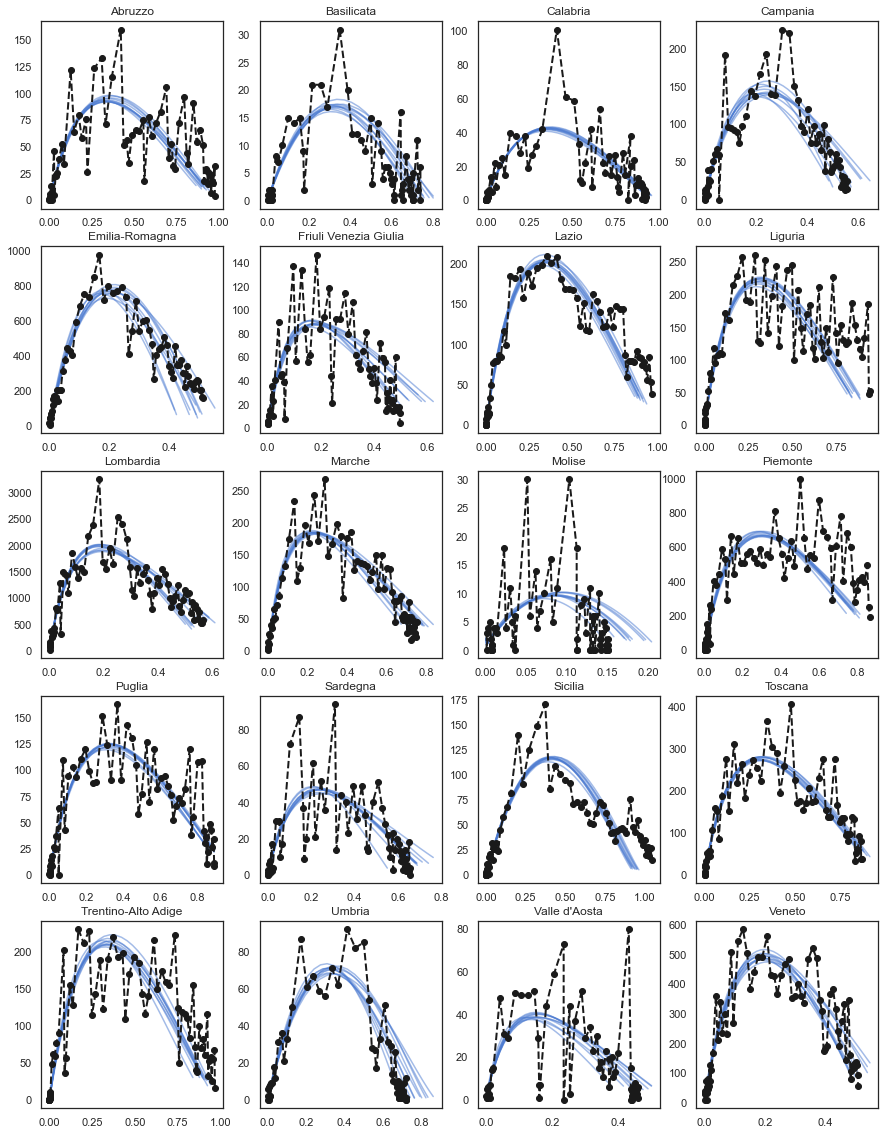

In [95]:
fig, axes = plt.subplots(5, 4, figsize=(15, 20))

ax = axes.flatten()
for i, key in enumerate(samples):
    for j in range(num_samples):
        if j % 100 == 0:
            ax[i].plot(samples[key]['X'][j], samples[key]['daily'][j], 'b', alpha=.5);
    
    X = datas[key][0]
    dX = datas[key][1]
    N = df_N['Population'].loc[df_N.Region == key].values[0]
    
    ax[i].plot(X / (samples[key]['f'].mean() * float(N)), dX, 'ko--', lw=2);
    ax[i].set_title(key)

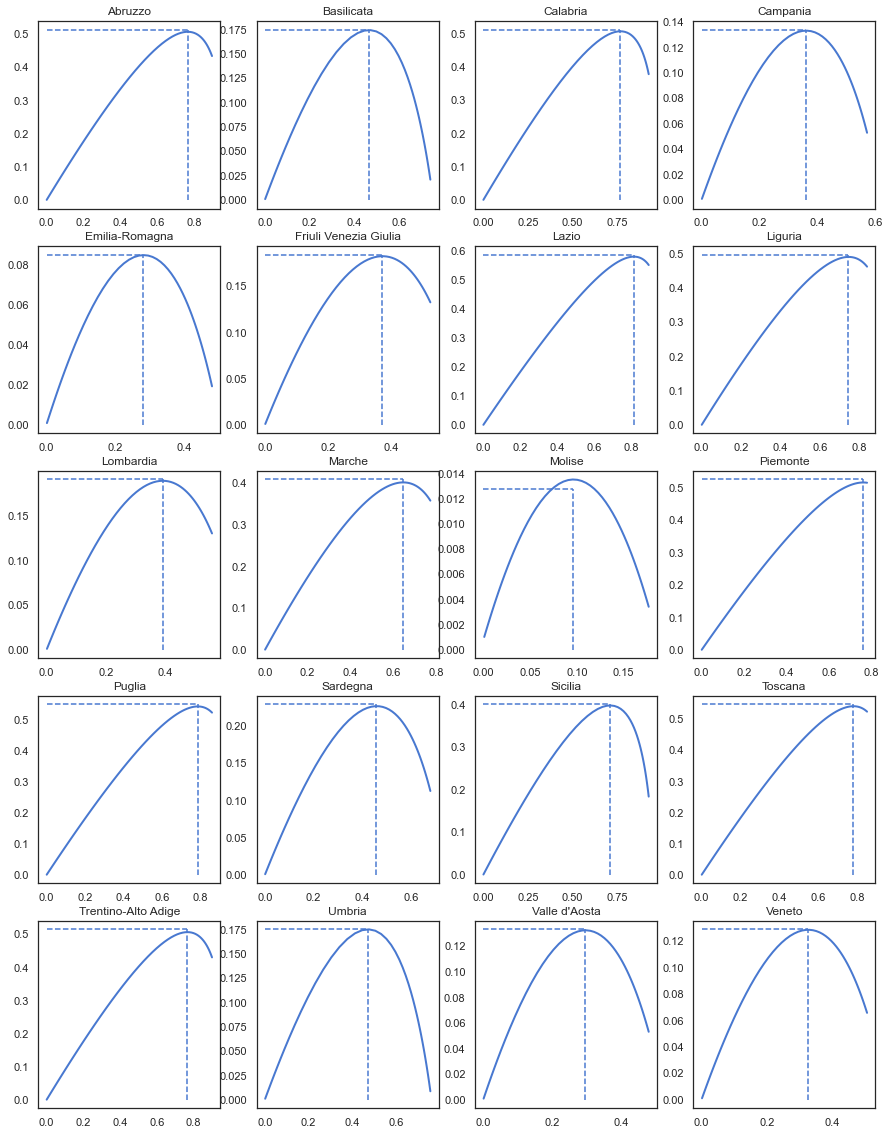

In [97]:
fig, axes = plt.subplots(5, 4, figsize=(15, 20))

ax = axes.flatten()
for i, key in enumerate(samples):
    
    ax[i].plot(samples[key]['X'].mean(0), samples[key]['I'].mean(0), 'b', lw=2);
    
    alpha = samples[key]['alpha']
    g0 = samples[key]['g0']
    
    X_peak = ((g0 - 1) / (g0 + alpha)).mean()
    I_peak = ((g0 - 1) / g0 + (1 + alpha) / g0 * (np.log(1 + alpha) - np.log(g0 + alpha))).mean()
    
    ax[i].vlines(X_peak, 0, I_peak, 'b', linestyle='--')
    ax[i].hlines(I_peak, 0, X_peak, 'b', linestyle='--')
    ax[i].set_title(key)

In [100]:
table = {r'$\alpha_X$': [],
         r'$g_0$': [],
         r'$\tau$': [],
         r'$\tau_2$': [],
         'CEI': [],}
for key in samples:
    alpha_x = samples[key]['alpha']
    table[r'$\alpha_X$'].append(alpha_x.mean())
    table[r'$g_0$'].append(samples[key]['g0'].mean())
    table['CEI'].append((alpha_x/(alpha_x + samples[key]['g0'])).mean())
    table[r'$\tau_2$'].append((np.log(samples[key]['tau'])/np.log(samples[key]['g0'])).mean())
    table[r'$\tau$'].append(samples[key]['tau'].mean())
    
df_tbl = pd.DataFrame(table)
df_tbl

,$\alpha_X$,$g_0$,$\tau$,$\tau_2$,CEI
0,2.42494,13.450112,45.986843,1.4923626,0.16578561
1,0.86660767,2.6607969,6.4771795,1.918013,0.24154107
2,2.079346,12.138027,38.19825,1.4743121,0.15634434
3,2.2297883,2.877475,9.1672945,2.1339753,0.43189216
4,2.191944,2.2672517,6.4613857,2.3229923,0.47406888
5,9.012057,7.059527,19.599316,1.5373715,0.56480515
6,2.4529479,19.112007,73.37419,1.479421,0.13005774
7,3.3352778,15.185059,55.341427,1.4959413,0.19612584
8,6.6226864,6.0139055,19.672382,1.6758721,0.5271172
9,6.9936757,17.47922,46.58604,1.3592333,0.31002146


In [101]:
samples = {}
datas = {}
for region in np.onp.unique(df_it_regions.region):
    if region != 'all':
        df = df_it_regions[['I', 'X', 'R', 'new daily cases']].loc[df_it_regions.region == region]
        df = df.loc[(df > 0).any(1)]
        df = df.where(df > 0, .1)
        data = {'R': np.array(df['R'].values),
                'I': np.array(df['I'].values),
                'X': np.array(df['X'].values),
                'dX': np.array(df['new daily cases'].values)}

        obs = data['X'].astype(np.float32)
        datas[region] = [data['X'], data['dX']]
        T = obs.shape[-1]
        N = df_N['Population'].loc[df_N.Region == region].values[0]
        
        nuts = NUTS(condition(model2, {'b': -200., 'k': 1.}), dense_mass=True)
        mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
        mcmc.run(random.PRNGKey(248323), T=T, N=N, data=data, obs=obs)
        print(region)
        mcmc.print_summary()
        samples[region] = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:57<00:00, 34.53it/s, 15 steps of size 2.30e-01. acc. prob=0.87]  


Abruzzo

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.73      0.39      2.70      2.12      3.38    557.23      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    623.12      1.00
        g0     10.60      4.32      9.51      5.56     15.80    143.40      1.00
      nu_X     16.12      2.29     16.08     12.83     20.25    533.98      1.00
       tau     35.17     15.58     31.16     17.11     53.63    144.92      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    784.03      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    867.34      1.00

Number of divergences: 1


sample: 100%|██████████| 2000/2000 [01:06<00:00, 30.04it/s, 31 steps of size 1.55e-01. acc. prob=0.86] 


Basilicata

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.92      0.32      0.89      0.42      1.44    378.39      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    148.87      1.00
        g0      2.39      0.38      2.33      1.82      2.84    113.53      1.00
      nu_X     10.06      1.17     10.02      8.29     12.13    507.20      1.00
       tau      5.48      1.32      5.29      3.57      7.07    115.33      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    455.29      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    977.80      1.00

Number of divergences: 10


sample: 100%|██████████| 2000/2000 [00:57<00:00, 34.54it/s, 7 steps of size 2.03e-01. acc. prob=0.91]  


Calabria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.36      0.31      2.36      1.81      2.84    789.10      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    721.27      1.00
        g0      9.92      3.74      9.03      5.29     15.01    272.26      1.02
      nu_X     14.23      1.91     14.14     11.11     17.35    663.76      1.00
       tau     30.34     12.47     27.45     15.02     47.64    275.25      1.02
 z_init[0]      0.00      0.00      0.00      0.00      0.00    780.90      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    715.88      1.00

Number of divergences: 2


sample: 100%|██████████| 2000/2000 [00:54<00:00, 36.46it/s, 15 steps of size 2.07e-01. acc. prob=0.84] 


Campania

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.20      0.60      3.20      2.29      4.22    253.96      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    314.65      1.00
        g0      2.09      0.22      2.05      1.74      2.43    143.44      1.00
      nu_X     23.24      2.95     23.11     18.48     28.06    500.60      1.00
       tau      5.37      0.94      5.22      3.78      6.73    143.89      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    365.74      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    817.36      1.00

Number of divergences: 20


sample: 100%|██████████| 2000/2000 [01:03<00:00, 31.57it/s, 31 steps of size 1.51e-01. acc. prob=0.91] 


Emilia-Romagna

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.94      0.92      3.94      2.35      5.40    424.52      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    662.54      1.00
        g0      1.76      0.14      1.75      1.52      1.97    300.45      1.00
      nu_X     23.49      2.90     23.32     18.84     28.12    562.11      1.00
       tau      3.90      0.59      3.86      2.87      4.74    302.20      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    626.11      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    988.19      1.01

Number of divergences: 2


sample: 100%|██████████| 2000/2000 [00:48<00:00, 41.13it/s, 15 steps of size 2.45e-01. acc. prob=0.88] 


Friuli Venezia Giulia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      9.57      1.12      9.49      8.06     11.58    920.89      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    254.15      1.00
        g0      2.58      0.38      2.51      1.98      3.13    170.27      1.00
      nu_X     25.92      3.28     25.84     20.67     31.28    524.82      1.00
       tau      5.31      1.08      5.11      3.53      6.76    170.90      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    645.70      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    918.59      1.00

Number of divergences: 7


sample: 100%|██████████| 2000/2000 [00:53<00:00, 37.60it/s, 15 steps of size 2.29e-01. acc. prob=0.82] 


Lazio

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.70      0.33      2.69      2.11      3.20    962.63      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    945.80      1.00
        g0     12.05      4.98     10.94      6.16     18.01    211.28      1.00
      nu_X     20.40      2.85     20.25     15.78     25.27    541.64      1.00
       tau     44.58     19.83     40.19     21.89     68.97    212.40      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    765.96      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    745.94      1.00

Number of divergences: 16


sample: 100%|██████████| 2000/2000 [00:51<00:00, 39.20it/s, 15 steps of size 2.21e-01. acc. prob=0.89] 


Liguria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.71      0.52      3.69      2.82      4.53    750.44      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    814.97      1.00
        g0      9.55      3.85      8.75      4.77     14.60    228.07      1.00
      nu_X     14.48      2.02     14.34     11.16     17.89    531.23      1.00
       tau     33.20     14.61     29.78     15.05     51.51    224.23      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    844.30      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    793.37      1.00

Number of divergences: 3


sample: 100%|██████████| 2000/2000 [00:52<00:00, 38.44it/s, 15 steps of size 2.03e-01. acc. prob=0.90] 


Lombardia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      7.24      0.88      7.21      5.95      8.80    722.68      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    434.75      1.00
        g0      2.55      0.33      2.51      2.06      3.06    213.35      1.00
      nu_X     32.22      3.83     31.92     26.17     38.76    651.63      1.00
       tau      6.30      1.16      6.16      4.60      8.10    213.35      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    706.69      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    799.56      1.00

Number of divergences: 3


sample: 100%|██████████| 2000/2000 [00:48<00:00, 41.08it/s, 15 steps of size 2.24e-01. acc. prob=0.85] 


Marche

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      7.72      0.81      7.69      6.54      9.11    724.51      1.00
      f[0]      0.01      0.00      0.01      0.00      0.01    167.70      1.01
        g0      4.88      1.41      4.60      3.00      6.68    125.62      1.02
      nu_X     18.84      2.42     18.80     14.93     22.52    526.88      1.00
       tau     11.17      3.85     10.42      6.05     16.07    126.69      1.02
 z_init[0]      0.00      0.00      0.00      0.00      0.00    437.99      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    744.41      1.00

Number of divergences: 10


sample: 100%|██████████| 2000/2000 [00:49<00:00, 40.40it/s, 15 steps of size 2.67e-01. acc. prob=0.92]  


Molise

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.68      1.38      1.26      0.26      3.51    291.61      1.00
      f[0]      0.00      0.00      0.00      0.00      0.01    882.61      1.00
        g0      1.17      0.02      1.17      1.14      1.21    518.12      1.00
      nu_X     13.18      1.60     13.18     10.16     15.50    936.86      1.00
       tau      1.52      0.12      1.51      1.32      1.70    597.41      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    865.90      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1041.64      1.00

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:52<00:00, 38.40it/s, 15 steps of size 2.46e-01. acc. prob=0.88] 


Piemonte

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.32      0.68      4.28      3.17      5.46    532.86      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    595.30      1.00
        g0     10.95      4.65      9.74      4.94     17.61    175.59      1.00
      nu_X     12.21      1.98     12.05      8.95     15.29    634.59      1.00
       tau     42.55     19.55     37.41     17.64     71.00    176.04      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    645.20      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    944.24      1.00

Number of divergences: 3


sample: 100%|██████████| 2000/2000 [00:53<00:00, 37.23it/s, 15 steps of size 2.00e-01. acc. prob=0.89] 


Puglia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.68      0.41      3.68      3.02      4.35    770.94      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    569.27      1.00
        g0      9.76      3.22      8.98      5.25     14.14    349.03      1.00
      nu_X     24.45      3.36     24.42     19.16     29.82    748.20      1.00
       tau     32.37     11.68     29.63     15.95     48.23    347.09      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    823.43      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    816.29      1.00

Number of divergences: 4


sample: 100%|██████████| 2000/2000 [00:46<00:00, 43.24it/s, 15 steps of size 2.12e-01. acc. prob=0.89]  


Sardegna

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      5.27      0.66      5.22      4.22      6.32    912.35      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    265.36      1.00
        g0      3.52      0.80      3.35      2.40      4.71    134.31      1.01
      nu_X     15.16      1.84     15.11     12.02     18.12    768.41      1.00
       tau      7.67      2.26      7.24      4.63     11.04    134.99      1.01
 z_init[0]      0.00      0.00      0.00      0.00      0.00    515.21      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    646.05      1.00

Number of divergences: 7


sample: 100%|██████████| 2000/2000 [00:59<00:00, 33.47it/s, 31 steps of size 1.27e-01. acc. prob=0.83] 


Sicilia

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.69      0.21      0.67      0.39      1.05    316.86      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    442.61      1.02
        g0      4.83      1.64      4.49      3.05      6.39     77.97      1.01
      nu_X     17.36      1.96     17.30     14.04     20.69    579.64      1.00
       tau     17.41      7.21     15.87      9.60     24.37     77.85      1.01
 z_init[0]      0.00      0.00      0.00      0.00      0.00    295.42      1.01
 z_init[1]      0.00      0.00      0.00      0.00      0.00     52.56      1.02

Number of divergences: 19


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.79it/s, 7 steps of size 2.40e-01. acc. prob=0.87]  


Toscana

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.14      0.45      4.13      3.44      4.90    940.70      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    742.88      1.00
        g0     10.87      4.28      9.74      5.45     16.54    272.00      1.01
      nu_X     20.72      2.80     20.70     16.02     25.33    845.51      1.00
       tau     35.98     15.27     31.91     17.06     56.48    273.30      1.01
 z_init[0]      0.00      0.00      0.00      0.00      0.00    820.23      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1338.35      1.00

Number of divergences: 5


sample: 100%|██████████| 2000/2000 [00:42<00:00, 46.78it/s, 15 steps of size 3.07e-01. acc. prob=0.93] 


Trentino-Alto Adige

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.76      0.50      2.74      2.01      3.63    807.82      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    953.77      1.00
        g0     12.44      6.26     11.06      5.79     18.75    128.04      1.00
      nu_X      4.48      0.78      4.43      3.23      5.71    823.17      1.00
       tau     42.49     22.37     37.82     18.76     66.19    130.49      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    922.83      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1247.56      1.00

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:55<00:00, 35.76it/s, 7 steps of size 2.03e-01. acc. prob=0.88]  


Umbria

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.02      0.26      1.00      0.61      1.45    527.78      1.00
      f[0]      0.00      0.00      0.00      0.00      0.00    340.02      1.00
        g0      2.30      0.24      2.26      1.95      2.66    226.63      1.00
      nu_X     22.83      2.81     22.70     18.63     27.62    630.18      1.00
       tau      4.75      0.78      4.61      3.52      5.89    233.61      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    492.47      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00   1051.86      1.00

Number of divergences: 6


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.38it/s, 31 steps of size 1.48e-01. acc. prob=0.84] 


Valle d'Aosta

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      9.62      1.29      9.58      7.29     11.57    464.89      1.00
      f[0]      0.01      0.00      0.01      0.01      0.02    246.64      1.00
        g0      2.68      0.51      2.58      1.95      3.42    311.74      1.00
      nu_X     11.19      1.37     11.19      9.02     13.50    459.14      1.00
       tau      4.48      1.16      4.26      2.84      6.08    312.46      1.00
 z_init[0]      0.00      0.00      0.00      0.00      0.00    580.53      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    787.06      1.00

Number of divergences: 7


sample: 100%|██████████| 2000/2000 [00:52<00:00, 37.97it/s, 15 steps of size 2.12e-01. acc. prob=0.92] 


Veneto

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.53      0.75      4.53      3.27      5.70    444.39      1.00
      f[0]      0.01      0.00      0.01      0.01      0.01    436.07      1.00
        g0      2.01      0.19      1.98      1.71      2.30    211.94      1.01
      nu_X     29.23      3.48     29.15     23.83     35.14    688.30      1.00
       tau      5.32      0.85      5.17      3.99      6.60    217.76      1.01
 z_init[0]      0.00      0.00      0.00      0.00      0.00    580.91      1.00
 z_init[1]      0.00      0.00      0.00      0.00      0.00    933.82      1.00

Number of divergences: 2


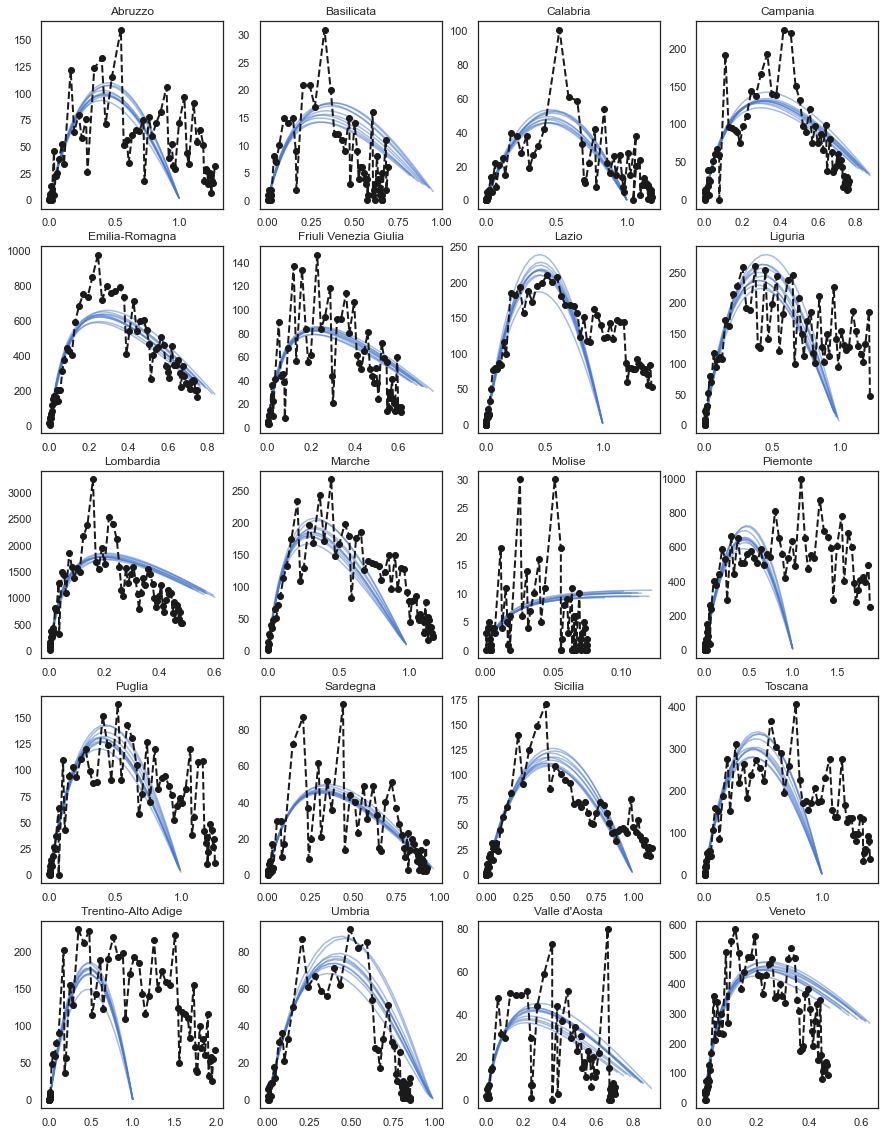

In [623]:
fig, axes = plt.subplots(5, 4, figsize=(15, 20))

ax = axes.flatten()
for i, key in enumerate(samples):
    for j in range(num_samples):
        if j % 100 == 0:
            ax[i].plot(samples[key]['X'][j], samples[key]['daily'][j], 'b', alpha=.5);
    
    X = datas[key][0]
    dX = datas[key][1]
    N = df_N['Population'].loc[df_N.Region == key].values[0]
    
    ax[i].plot(X / (samples[key]['f'].mean() * float(N)), dX, 'ko--', lw=2);
    ax[i].set_title(key)

In [103]:
region = 'Lazio'

df = df_it_regions[['I', 'X', 'R', 'new daily cases']].loc[df_it_regions.region == region]
df = df.loc[(df > 0).any(1)]
df = df.where(df > 0, .1)
data = {'R': np.array(df['R'].values),
        'I': np.array(df['I'].values),
        'X': np.array(df['X'].values),
        'dX': np.array(df['new daily cases'].values)}

obs = data['X'].astype(np.float32)
T = obs.shape[-1]
N = df_N['Population'].loc[df_N.Region == region].values[0]

nuts = NUTS(condition(model2, {'k': 1.}), dense_mass=True)
mcmc = MCMC(nuts, num_warmup, num_samples, num_chains=num_chains)
mcmc.run(random.PRNGKey(248324323), T=T, N=N, data=data, obs=obs)
mcmc.print_summary()
samples_lazio = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [14:48<00:00,  2.25it/s, 1023 steps of size 5.20e-04. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      8.06      0.76      8.09      6.50      9.07      4.46      1.64
         b     -4.55      0.14     -4.55     -4.77     -4.31     10.04      1.37
      f[0]      0.00      0.00      0.00      0.00      0.00      2.71      2.16
        g0      1.97      0.09      1.98      1.81      2.10     12.12      1.32
      nu_X      3.13      0.16      3.11      2.87      3.35      2.97      1.95
       tau      5.16      0.46      5.16      4.34      5.84      6.23      1.64
 z_init[0]      0.00      0.00      0.00      0.00      0.00     17.68      1.14
 z_init[1]      0.00      0.00      0.00      0.00      0.00     11.70      1.24

Number of divergences: 0


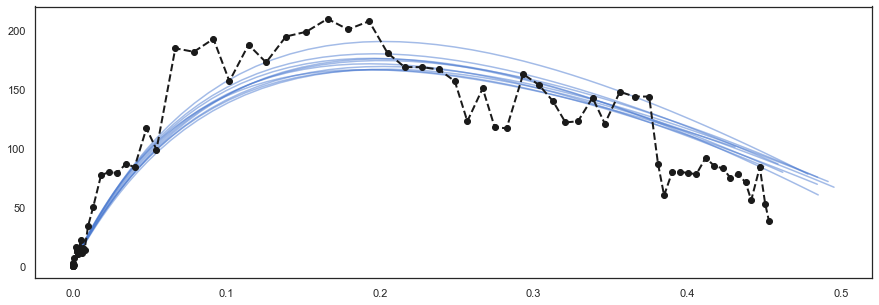

In [104]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for j in range(num_samples):
    if j % 100 == 0:
        plt.plot(samples_lazio['X'][j], samples_lazio['daily'][j], 'b', alpha=.5);

X = data['X']
dX = data['dX']
N = df_N['Population'].loc[df_N.Region == region].values[0]

plt.plot(X / (samples_lazio['f'].mean() * float(N)), dX, 'ko--', lw=2);